# Data Loading and Preprocessing

In [1]:
pip install scikit-posthocs


  Using cached scikit_posthocs-0.11.4-py3-none-any.whl.metadata (5.8 kB)
Using cached scikit_posthocs-0.11.4-py3-none-any.whl (33 kB)


In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway, kruskal,chi2_contingency
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scikit_posthocs as sp
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [4]:
df = pd.read_csv(r"C:\Users\Admin\Desktop\Jwala\WA_Marketing-Campaign.csv")

In [5]:
df.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81


# Deriving columns

In [6]:
#Converting the Age of a store as a categorical variable with categories as (new-0,mid-1,established-2)
def categorize_age(age):
    if age <= 2:
        return 0
    elif age <= 7:
        return 1
    else:
        return 2

df['StoreAgeCategory'] = df['AgeOfStore'].apply(categorize_age)

In [7]:
# Calculating the SalesPerAge

df['SalesPerAge'] = df['SalesInThousands']/df['AgeOfStore']

In [8]:
#A pivot Table to showacase the average sales of the store based on it's age category

MeanSales_BasedOnAge = pd.pivot_table(df,values='SalesPerAge',index = ['StoreAgeCategory'],aggfunc='mean')
MeanSales_BasedOnAge

,SalesPerAge
StoreAgeCategory,
0,52.650450
1,11.560838
2,4.168362


In [9]:
# Calculate the lagged Sales for a store to Compare the current sales to previous week sales

df = df.sort_values(['LocationID', 'week'])
df['LaggedSales'] = df.groupby('LocationID')['SalesInThousands'].shift(1)

In [10]:
# Caculating the Change in Sales per Week
df['ChangeInSalesPerWeek'] = df['SalesInThousands'] - df['LaggedSales']

# Calculating the Change in sale percentage compared to the previous week.
df['SalesGrowthRate'] = df.groupby('LocationID')['SalesInThousands'].pct_change()
df['SalesGrowthRate'] = df['SalesGrowthRate']*100

In [11]:
# A pivot table to show the average sales in stores based on the week (1,2,3,4)
MeanSales_perweek = pd.pivot_table(df,values='SalesInThousands',index=['week'],aggfunc='mean')
MeanSales_perweek

,SalesInThousands
week,
1,53.790584
2,53.386569
3,53.474599
4,53.213066


In [12]:
# Avergae Market Sales in the same marketID and Same Promotion
df['AvgMarketSales'] = df.groupby(['MarketID', 'Promotion'])['SalesInThousands'].transform('mean')

# Relative Sales of the store with respect to the average sales in the same marketID and same Promotion
df['RelativeSales'] = df['SalesInThousands'] / df['AvgMarketSales']

In [13]:
# Average sales based on same week , same MarketID and same promotion
df['AvgSalesBasedOnWeek'] = df.groupby(['MarketID','week','Promotion'])['SalesInThousands'].transform('mean')

In [14]:
# PromoSuccessScore: performance relative to average for the same promotion and MarketID
promo_avg = df.groupby(['Promotion','MarketID'])['SalesInThousands'].transform('mean')
df['MarketBased_PromoSuccessScore'] = df['SalesInThousands'] - promo_avg

In [15]:
# Deviation From Average sales based on same promotion and MarketID
df['DeviationFromAvgPromo'] = df['SalesInThousands'] - df['AvgSalesBasedOnWeek']

In [16]:
df.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands,StoreAgeCategory,SalesPerAge,LaggedSales,ChangeInSalesPerWeek,SalesGrowthRate,AvgMarketSales,RelativeSales,AvgSalesBasedOnWeek,MarketBased_PromoSuccessScore,DeviationFromAvgPromo
0,1,Medium,1,4,3,1,33.73,1,8.4325,NaN,NaN,NaN,33.989167,0.992375,33.350000,-0.259167,0.380000
1,1,Medium,1,4,3,2,35.67,1,8.9175,33.73,1.94,5.751556,33.989167,1.049452,31.926667,1.680833,3.743333
2,1,Medium,1,4,3,3,29.03,1,7.2575,35.67,-6.64,-18.615083,33.989167,0.854096,35.286667,-4.959167,-6.256667
3,1,Medium,1,4,3,4,39.25,1,9.8125,29.03,10.22,35.204960,33.989167,1.154780,35.393333,5.260833,3.856667
4,1,Medium,2,5,2,1,27.81,1,5.5620,NaN,NaN,NaN,30.152000,0.922327,32.362000,-2.342000,-4.552000


In [17]:
# A pivot Table to show Market Based Promo success score based on weeks

pivot_week=pd.pivot_table(df, values = 'MarketBased_PromoSuccessScore',index=(['week']),aggfunc='mean')
pivot_week

,MarketBased_PromoSuccessScore
week,
1,0.324380
2,-0.079635
3,0.008394
4,-0.253139


# Visualising the performance of the promotions through sales in thousands

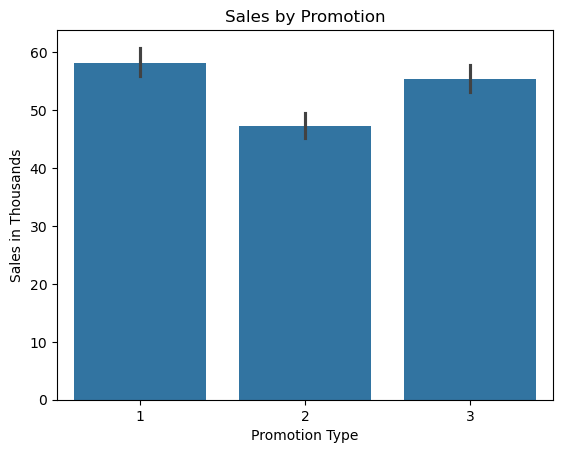

In [18]:
# Visualising the distributions of Sales in Thousands based on Promotion

sns.barplot(x='Promotion', y='SalesInThousands', data=df)
plt.title('Sales by Promotion')
plt.ylabel('Sales in Thousands')
plt.xlabel('Promotion Type')
plt.show()

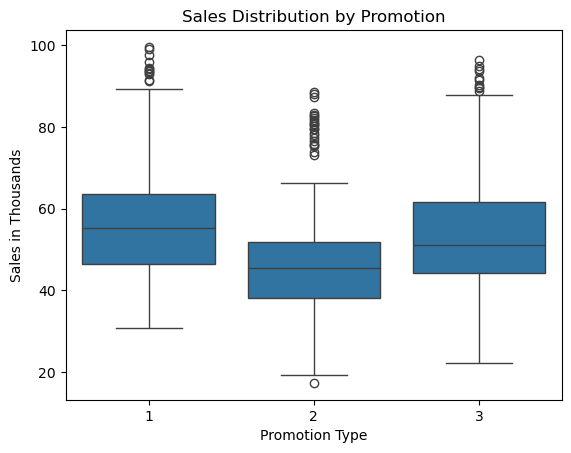

In [19]:
# Visualising the distributions of Sales in Thousands based on Promotion

sns.boxplot(x='Promotion', y='SalesInThousands', data=df)
plt.title('Sales Distribution by Promotion')
plt.ylabel('Sales in Thousands')
plt.xlabel('Promotion Type')
plt.show()

In [20]:
#Descriptive measures for Sales in Thousands based on Promotion strategies
df.groupby(['Promotion'])['SalesInThousands'].agg(['mean', 'median', 'std', 'count'])

,mean,median,std,count
Promotion,,,,
1,58.099012,55.385,16.553782,172
2,47.329415,45.385,15.108955,188
3,55.364468,51.165,16.766231,188


# A/B/C Testing

In [21]:
# Perform One way ANOVA 

# Hypothesis Framing

# Null Hypothesis : There is no difference in the mean sales based on the promotion strategy.
# Alternative Hypothesis : There is a significant difference in the mean sales based on the promotion strategy.
# Level of Significance : 5%

# Sales grouped by promotion
group1 = df[df['Promotion'] == 1]['SalesInThousands']
group2 = df[df['Promotion'] == 2]['SalesInThousands']
group3 = df[df['Promotion'] == 3]['SalesInThousands']

# ANOVA test
f_stat, p_value = f_oneway(group1, group2, group3)
print(f"F-statistic: {f_stat:.3f}, p-value: {p_value:.4f}")

if p_value < 0.05:
    print("\nThere is a significant difference in the mean sales based on the promotion strategy. (Reject Ho)")
else:
    print("\nThere is no significant difference in the mean sales based on the promotion strategy. (Reject H1)")

F-statistic: 21.953, p-value: 0.0000

There is a significant difference in the mean sales based on the promotion strategy. (Reject Ho)


In [22]:
# To check which pairs differ

tukey = pairwise_tukeyhsd(endog=df['SalesInThousands'], groups=df['Promotion'], alpha=0.05)
print(tukey)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     1      2 -10.7696    0.0 -14.7738 -6.7654   True
     1      3  -2.7345 0.2444  -6.7388  1.2697  False
     2      3   8.0351    0.0   4.1208 11.9493   True
-----------------------------------------------------


In [23]:
# Perform the non parametric equivalent Kruskal Wallis

# Hypothesis Framing

# Null Hypothesis : There is no difference in the distribution of sales based on the promotion strategy.
# Alternative Hypothesis : There is a significant difference in the distribution of sales based on the promotion strategy.
# Level of Significance : 5%

# Sales grouped by promotion
group1 = df[df['Promotion'] == 1]['SalesInThousands']
group2 = df[df['Promotion'] == 2]['SalesInThousands']
group3 = df[df['Promotion'] == 3]['SalesInThousands']

# Kruskall Wallis test
h_stat, p_value = kruskal(group1, group2, group3)
print(f"H-statistic: {h_stat:.3f}, p-value: {p_value:.4f}")

if p_value < 0.05:
    print("\nThere is a significant difference in the distribution of sales based on the promotion strategy. (Reject Ho)")
else:
    print("\nThere is no difference in the distribution of sales based on the promotion strategy. (Reject H1)")

H-statistic: 53.295, p-value: 0.0000

There is a significant difference in the distribution of sales based on the promotion strategy. (Reject Ho)


In [24]:
# Dunn's Test

# A Dunn test with Bonferroni correction
dunn_results = sp.posthoc_dunn(df, val_col='SalesInThousands', group_col='Promotion', p_adjust='bonferroni')
print(dunn_results)

              1             2             3
1  1.000000e+00  6.461842e-12  1.458660e-01
2  6.461842e-12  1.000000e+00  7.083069e-07
3  1.458660e-01  7.083069e-07  1.000000e+00


# Visualising Mean Sales Based on Promotion and Marketsizes

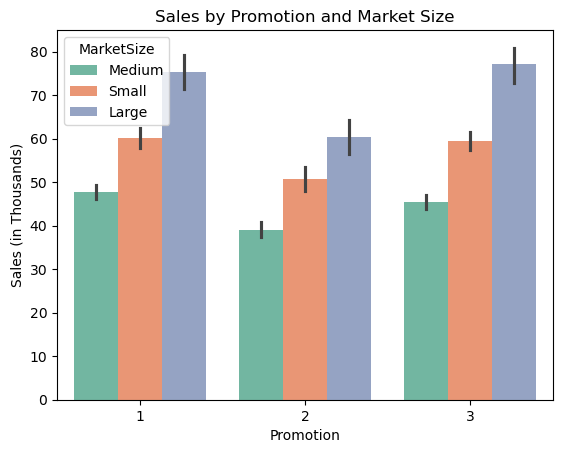

In [25]:
# Mean Sales by Promotion + MarketSize

sns.barplot(data=df, x='Promotion', y='SalesInThousands', hue='MarketSize', palette='Set2')
plt.title('Sales by Promotion and Market Size')
plt.ylabel('Sales (in Thousands)')
plt.show()

In [26]:
# Descriptive Measures of SalesInThousands grouped by MarketSize and Promotion Type
df.groupby(['Promotion','MarketSize'])['SalesInThousands'].agg(['mean','median','std','count'])

mean  median        std  count
Promotion MarketSize                                     
1         Large       75.235893  72.835  15.497497     56
          Medium      47.672604  47.425   8.067331     96
          Small       60.162500  61.145   5.127279     20
2         Large       60.322031  53.010  15.728529     64
          Medium      39.114352  39.765   8.807407    108
          Small       50.810625  51.600   5.869816     16
3         Large       77.203958  82.345  14.400304     48
          Medium      45.468879  46.295   8.091366    116
          Small       59.514167  59.745   5.212687     24

# A/B/C Testing

In [27]:
# Performing Two Way ANOVA 

# Hypotheses framing

# Null Hypothesis : No effect of Promotion, MarketSize, or their interaction on Sales.
# Alternative Hypothesis : At least one factor (or their interaction) has a significant effect.

import statsmodels.api as sm
from statsmodels.formula.api import ols

# Ensure MarketSize is categorical
df['MarketSize'] = df['MarketSize'].astype('category')

# Two-way ANOVA model
model = ols('SalesInThousands ~ C(Promotion) + C(MarketSize) + C(Promotion):C(MarketSize)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)  # Type II ANOVA
print(anova_table)

                                  sum_sq     df           F        PR(>F)
C(Promotion)                12979.270759    2.0   56.241683  6.549744e-23
C(MarketSize)               77803.041539    2.0  337.135582  1.087739e-95
C(Promotion):C(MarketSize)   2116.739627    4.0    4.586120  1.194444e-03
Residual                    62194.324249  539.0         NaN           NaN


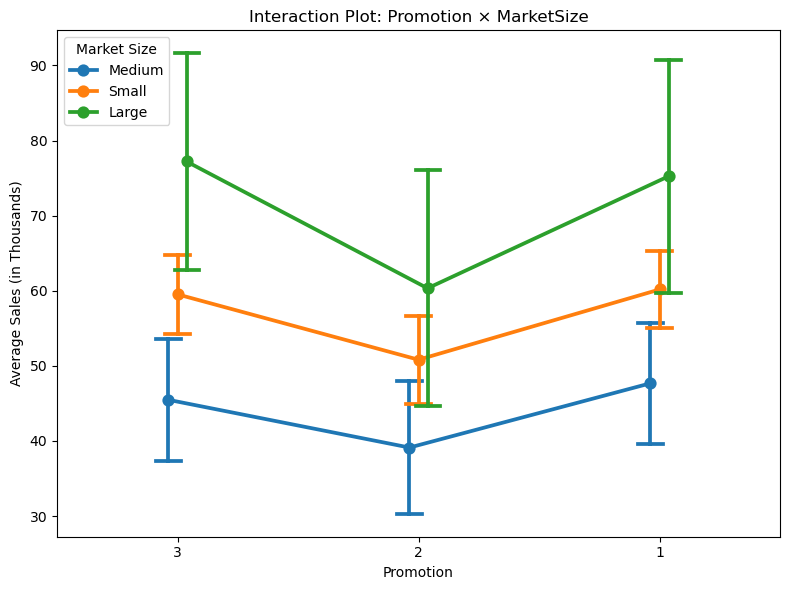

In [28]:
# Visualising the Interaction effecs of Market Sizes and Promotions

df['Promotion'] = df['Promotion'].astype(str)
df['MarketSize'] = df['MarketSize'].astype(str)

# Plot interaction: mean Sales by Promotion and MarketSize
plt.figure(figsize=(8, 6))
sns.pointplot(data=df, x='Promotion', y='SalesInThousands', hue='MarketSize', dodge=True, errorbar='sd', markers='o', capsize=0.1)
plt.title('Interaction Plot: Promotion × MarketSize')
plt.ylabel('Average Sales (in Thousands)')
plt.xlabel('Promotion')
plt.legend(title='Market Size')
plt.tight_layout()
plt.show()

In [29]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Tukey HSD test for each MarketSize
for size in df['MarketSize'].unique():
    print(f"\nTukey HSD for MarketSize = {size}")
    subset = df[df['MarketSize'] == size]
    tukey = pairwise_tukeyhsd(endog=subset['SalesInThousands'],
                              groups=subset['Promotion'],
                              alpha=0.05)
    print(tukey)


Tukey HSD for MarketSize = Medium
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     1      2  -8.5583    0.0 -11.3107 -5.8058   True
     1      3  -2.2037 0.1356  -4.9111  0.5037  False
     2      3   6.3545    0.0   3.7307  8.9783   True
-----------------------------------------------------

Tukey HSD for MarketSize = Small
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1      2  -9.3519    0.0 -13.683 -5.0208   True
     1      3  -0.6483 0.9161 -4.5579  3.2612  False
     2      3   8.7035    0.0  4.5359 12.8712   True
----------------------------------------------------

Tukey HSD for MarketSize = Large
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper  reject
------------------------------------------

# Checking for Novelty Effect 
(Good performance in early weeks but not so much after that)

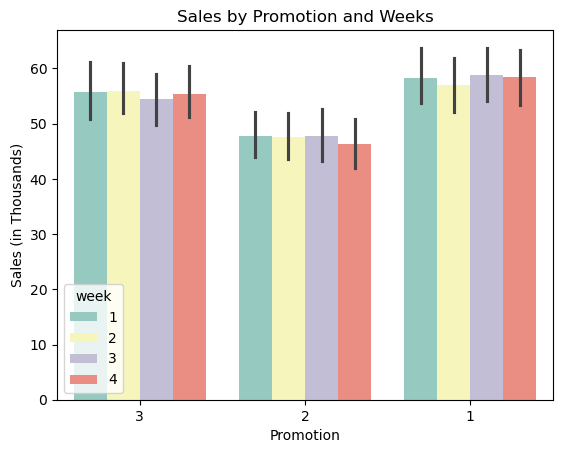

In [30]:
# Visualise the Sales grouped by week and Promotion

sns.barplot(data=df, x='Promotion', y='SalesInThousands', hue='week', palette='Set3')
plt.title('Sales by Promotion and Weeks')
plt.ylabel('Sales (in Thousands)')
plt.show()

In [31]:
# Descriptive Measures for Sales grouped By week and Promotions

df.groupby(['Promotion','week'])['SalesInThousands'].agg(['mean','median','std','count'])

mean  median        std  count
Promotion week                                     
1         1     58.244419   53.79  16.798929     43
          2     56.929535   55.11  16.553088     43
          3     58.774884   56.19  16.423121     43
          4     58.447209   56.84  16.962984     43
2         1     47.730213   46.02  14.387406     47
          2     47.582553   45.75  14.854098     47
          3     47.722128   45.35  15.979831     47
          4     46.282766   44.84  15.604704     47
3         1     55.776170   51.01  18.071909     47
          2     55.949149   53.47  15.643490     47
          3     54.377872   50.55  17.219269     47
          4     55.354681   50.05  16.535599     47

# A/B/C Testing

In [32]:
# Peform Two Way ANOVA

import statsmodels.api as sm
from statsmodels.formula.api import ols

# Hypotheses Generation
# Null Hypothesis : There is no difference in mean sales across different promotion types/ week
# Alternative Hypothesis : At least one promotion/week Category leads to a different mean sales compared to others.

# Interaction Effect
# Null Hypothesis : There is no interaction between promotion type and week; the effect of promotion on sales is independent of week.
# Alternative Hypothesis : There is an interaction; the effectiveness of a promotion depends on the week.


# Two-way ANOVA model
model = ols('SalesInThousands ~ C(Promotion) + C(week) + C(Promotion):C(week)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)  # Type II ANOVA
print(anova_table)

                             sum_sq     df          F        PR(>F)
C(Promotion)           11449.174291    2.0  21.624985  9.291171e-10
C(week)                   24.072749    3.0   0.030312  9.928936e-01
C(Promotion):C(week)     199.586322    6.0   0.125658  9.931963e-01
Residual              141890.446344  536.0        NaN           NaN


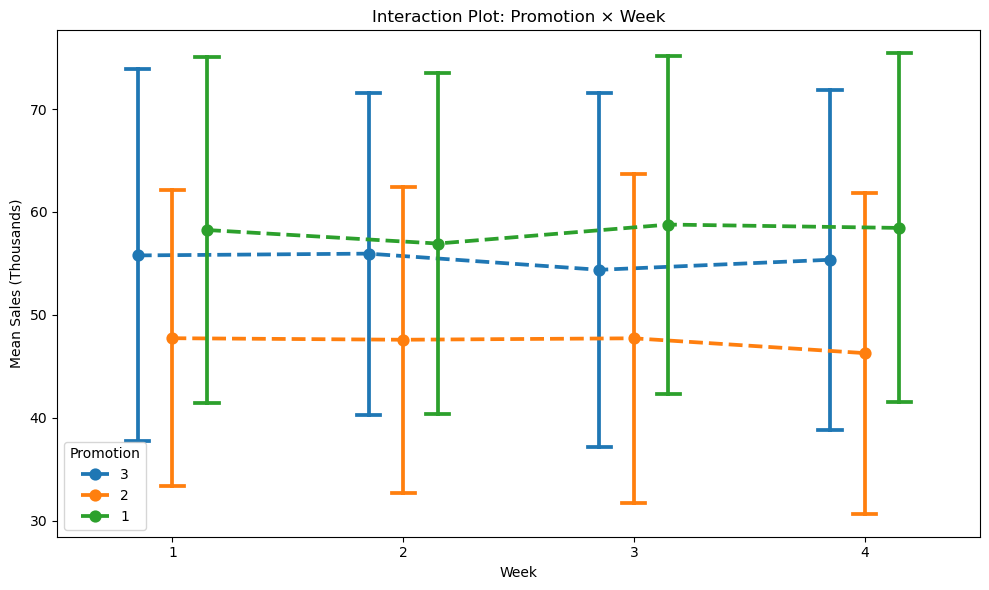

In [33]:
# Interaction plot: Mean sales for each promotion across weeks
plt.figure(figsize=(10, 6))
sns.pointplot(data=df, x='week', y='SalesInThousands', hue='Promotion',
              errorbar='sd', capsize=0.1, dodge=0.3, markers='o', linestyles='--', palette='tab10')
plt.title('Interaction Plot: Promotion × Week')
plt.xlabel('Week')
plt.ylabel('Mean Sales (Thousands)')
plt.legend(title='Promotion')
plt.tight_layout()
plt.show()

# Performance of the Campaign Based on Age of the store

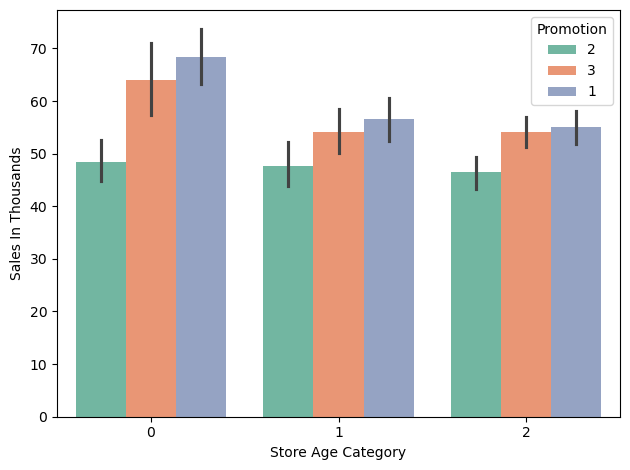

In [34]:
# Visualising Sales based on Age of the store

sns.barplot(data=df,x='StoreAgeCategory',y='SalesInThousands',hue='Promotion',palette='Set2')
plt.ylabel('Sales In Thousands')
plt.xlabel('Store Age Category')
plt.legend(title='Promotion')
plt.tight_layout()
plt.show()

In [35]:
# Descriptive Measures for Sales grouped by Age and Promotion
df.groupby(['StoreAgeCategory','Promotion'])['SalesInThousands'].agg(['mean','median','std','count'])

mean  median        std  count
StoreAgeCategory Promotion                                     
0                1          68.364063  62.335  15.283343     32
                 2          48.467045  47.800  13.713760     44
                 3          64.026667  56.725  17.717489     24
1                1          56.663594  51.685  17.654916     64
                 2          47.684375  45.665  17.206465     64
                 3          54.156471  50.060  18.675593     68
2                1          54.985658  53.735  14.486993     76
                 2          46.419750  44.670  14.150378     80
                 3          54.054583  51.115  14.478344     96

# A/B/C Testing

In [36]:
# Peform Two Way ANOVA

# Hypotheses Generation
# Null Hypothesis : There is no difference in mean sales across different promotion types/ Age Categories
# Alternative Hypothesis : At least one promotion/Age Category leads to a different mean sales compared to others.

# Interaction Effect
# Null Hypothesis : There is no interaction between promotion type and store age category; the effect of promotion on sales is independent of store age.
# Alternative Hypothesis : There is an interaction; the effectiveness of a promotion depends on the store's age category.

# Two-way ANOVA model
model = ols('SalesInThousands ~ C(Promotion) + C(StoreAgeCategory) + C(Promotion):C(StoreAgeCategory)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)  # Type II ANOVA
print(anova_table)

                                         sum_sq     df          F  \
C(Promotion)                       12531.961020    2.0  24.892541   
C(StoreAgeCategory)                 4366.640982    2.0   8.673566   
C(Promotion):C(StoreAgeCategory)    2069.735164    4.0   2.055583   
Residual                          135677.729268  539.0        NaN   

                                        PR(>F)  
C(Promotion)                      4.568936e-11  
C(StoreAgeCategory)               1.960942e-04  
C(Promotion):C(StoreAgeCategory)  8.536190e-02  
Residual                                   NaN  


In [38]:
# Tukey HSD test for each StorAgeCategory

for age in df['StoreAgeCategory'].unique():
    print(f"\nTukey HSD for Store Age Category = {age}")
    subset = df[df['StoreAgeCategory'] == age]
    
    if subset['Promotion'].nunique() >= 2:
        tukey = pairwise_tukeyhsd(endog=subset['SalesInThousands'],
                                  groups=subset['Promotion'],
                                  alpha=0.05)
        print(tukey)
    else:
        print("Not enough promotion groups for comparison.")



Tukey HSD for Store Age Category = 1
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     1      2  -8.9792 0.0137 -16.4421 -1.5164   True
     1      3  -2.5071 0.7001  -9.8594  4.8452  False
     2      3   6.4721 0.0968  -0.8802 13.8244  False
-----------------------------------------------------

Tukey HSD for Store Age Category = 2
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1      2  -8.5659 0.0007 -13.996 -3.1358   True
     1      3  -0.9311 0.9067 -6.1361  4.2739  False
     2      3   7.6348 0.0015   2.503 12.7667   True
----------------------------------------------------

Tukey HSD for Store Age Category = 0
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
---------------------------

# Logistic Regresssion

In [39]:
df.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands,StoreAgeCategory,SalesPerAge,LaggedSales,ChangeInSalesPerWeek,SalesGrowthRate,AvgMarketSales,RelativeSales,AvgSalesBasedOnWeek,MarketBased_PromoSuccessScore,DeviationFromAvgPromo
0,1,Medium,1,4,3,1,33.73,1,8.4325,NaN,NaN,NaN,33.989167,0.992375,33.350000,-0.259167,0.380000
1,1,Medium,1,4,3,2,35.67,1,8.9175,33.73,1.94,5.751556,33.989167,1.049452,31.926667,1.680833,3.743333
2,1,Medium,1,4,3,3,29.03,1,7.2575,35.67,-6.64,-18.615083,33.989167,0.854096,35.286667,-4.959167,-6.256667
3,1,Medium,1,4,3,4,39.25,1,9.8125,29.03,10.22,35.204960,33.989167,1.154780,35.393333,5.260833,3.856667
4,1,Medium,2,5,2,1,27.81,1,5.5620,NaN,NaN,NaN,30.152000,0.922327,32.362000,-2.342000,-4.552000


In [55]:
lg=df[['MarketSize','AgeOfStore','Promotion','week','SalesInThousands']].copy()
lg['week']=lg['week'].astype(str)
lg.head()

,MarketSize,AgeOfStore,Promotion,week,SalesInThousands
0,Medium,4,3,1,33.73
1,Medium,4,3,2,35.67
2,Medium,4,3,3,29.03
3,Medium,4,3,4,39.25
4,Medium,5,2,1,27.81


# EDA

In [63]:
lg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   MarketSize        548 non-null    object  
 1   AgeOfStore        548 non-null    int64   
 2   Promotion         548 non-null    object  
 3   week              548 non-null    object  
 4   SalesInThousands  548 non-null    float64 
 5   SalesCategory     548 non-null    category
dtypes: category(1), float64(1), int64(1), object(3)
memory usage: 22.2+ KB


In [64]:
lg.describe()

,AgeOfStore,SalesInThousands
count,548.000000,548.000000
mean,8.503650,53.466204
std,6.638345,16.755216
min,1.000000,17.340000
25%,4.000000,42.545000
50%,7.000000,50.200000
75%,12.000000,60.477500
max,28.000000,99.650000


In [65]:
lg.isnull().sum()

MarketSize          0
AgeOfStore          0
Promotion           0
week                0
SalesInThousands    0
SalesCategory       0
dtype: int64

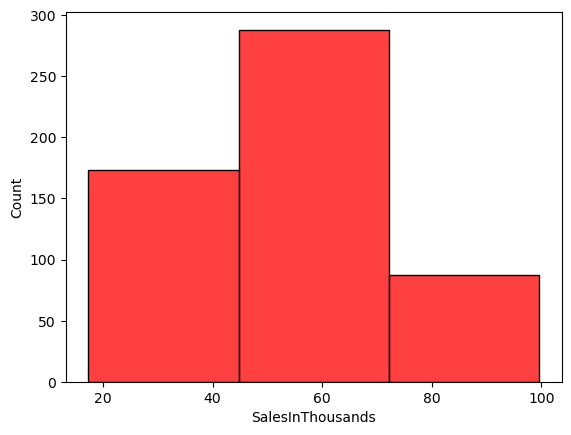

In [61]:
# Distribution of the target variable
sns.histplot(lg['SalesInThousands'],bins=3,color='red')
plt.show()

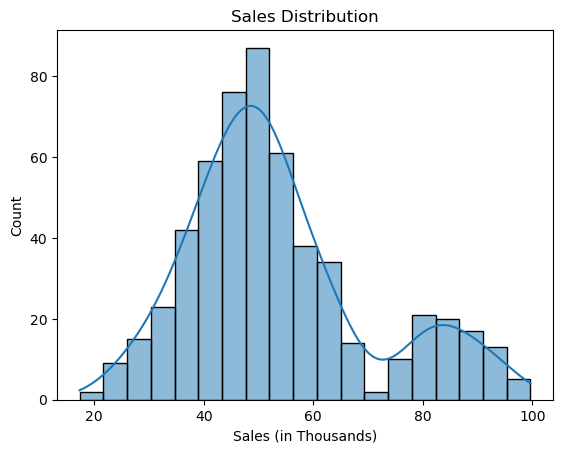

In [67]:
# Density Plot of the Target variable
sns.histplot(lg['SalesInThousands'], kde=True)
plt.title("Sales Distribution")
plt.xlabel("Sales (in Thousands)")
plt.show()

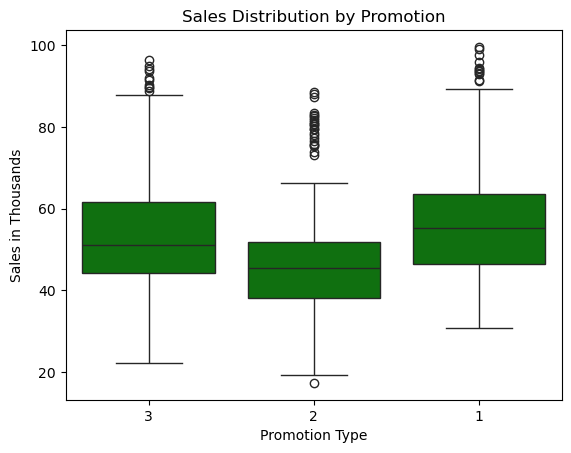

In [69]:
# Visualising the distributions of Sales in Thousands based on Promotion

sns.boxplot(x='Promotion', y='SalesInThousands', data=lg,color='green')
plt.title('Sales Distribution by Promotion')
plt.ylabel('Sales in Thousands')
plt.xlabel('Promotion Type')
plt.show()

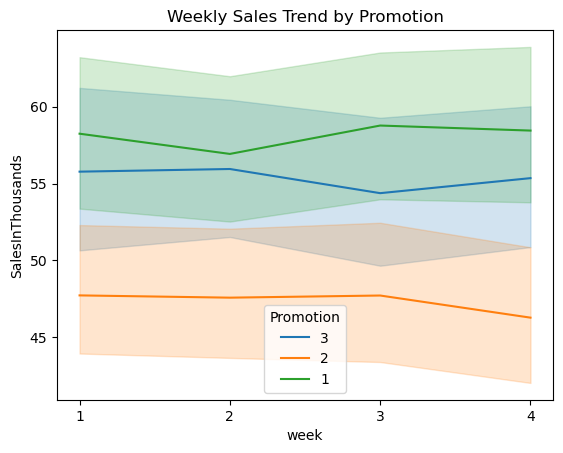

In [70]:
# Visualising Sales Based on week and promotion
sns.lineplot(x='week', y='SalesInThousands', hue='Promotion', data=lg)
plt.title("Weekly Sales Trend by Promotion")
plt.show()

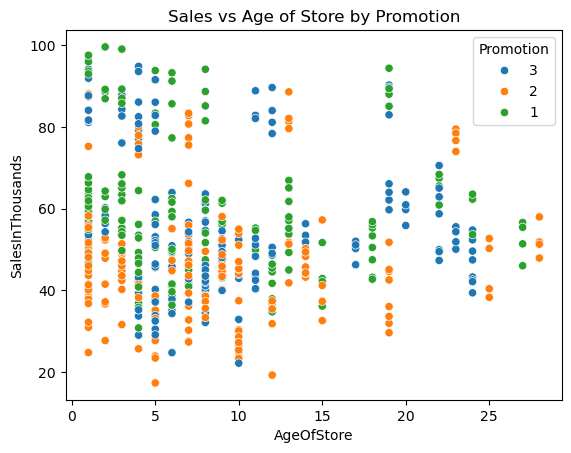

In [73]:
# Visualising Sales based on Age of store and promotions
sns.scatterplot(x='AgeOfStore', y='SalesInThousands', hue='Promotion', data=lg)
plt.title("Sales vs Age of Store by Promotion")
plt.show()

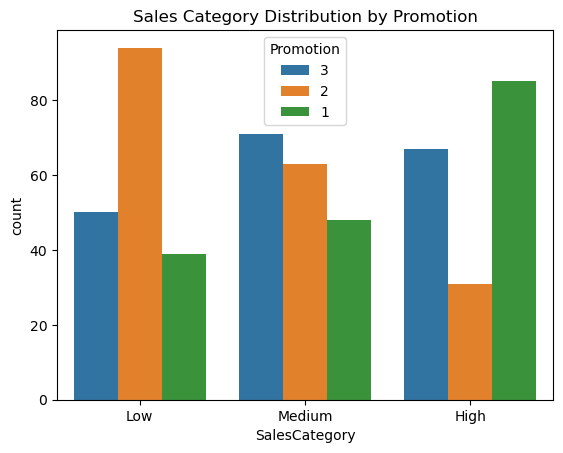

In [74]:
# Derving a categorical variable for sales

lg['SalesCategory'] = pd.qcut(lg['SalesInThousands'], q=3, labels=['Low', 'Medium', 'High'])
sns.countplot(x='SalesCategory', hue='Promotion', data=lg)
plt.title("Sales Category Distribution by Promotion")
plt.show()

# Chi- Square- Test

In [78]:
# Creating a contingency table
contingency_table = pd.crosstab(lg['Promotion'], lg['SalesCategory'])

# chi-square test
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

print("Chi-Square Statistic:", chi2_stat)
print("Degrees of Freedom:", dof)
print("P-Value:", p_val)

# show table
print("\nObserved Table:\n", contingency_table)
print("\nExpected Table:\n", pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns))

if p_val <0.05:
    print("\n\nConclusion: There is significant association between promotion type and sales category.")
else:
    print("\n\nnConclusion: There is no significant association between promotion type and sales category.")

Chi-Square Statistic: 56.27894096315831
Degrees of Freedom: 4
P-Value: 1.752527743169853e-11

Observed Table:
 SalesCategory  Low  Medium  High
Promotion                       
1               39      48    85
2               94      63    31
3               50      71    67

Expected Table:
 SalesCategory        Low     Medium       High
Promotion                                     
1              57.437956  57.124088  57.437956
2              62.781022  62.437956  62.781022
3              62.781022  62.437956  62.781022


Conclusion: There is significant association between promotion type and sales category.


# Logistic Regression

In [85]:
# Independent Variables
lg1=lg[['MarketSize','Promotion','week']].copy()
lg1=pd.get_dummies(lg[['MarketSize','Promotion','week']],drop_first=True).astype(int)
lg1=pd.concat([lg1,lg['AgeOfStore']],axis=1)
lg1.head()

,MarketSize_Medium,MarketSize_Small,Promotion_2,Promotion_3,week_2,week_3,week_4,AgeOfStore
0,1,0,0,1,0,0,0,4
1,1,0,0,1,1,0,0,4
2,1,0,0,1,0,1,0,4
3,1,0,0,1,0,0,1,4
4,1,0,1,0,0,0,0,5


In [86]:
# Dependent Variable
le=LabelEncoder()
y = le.fit_transform(lg['SalesCategory'])

In [88]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(lg1, y, test_size=0.3, random_state=42)

In [96]:
# Fit model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)

C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial')

In [97]:
# Evaluate
print("Train accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))

Train accuracy: 0.6161879895561357
Test accuracy: 0.6181818181818182


In [102]:
# Coefficient Interpretation

feature_names = X_train.columns

for i, class_idx in enumerate(model.classes_):
    class_name = le.inverse_transform([class_idx])[0]
    print(f"\nClass '{class_name}' coefficients:")
    for coef, fname in zip(model.coef_[i], feature_names):
        print(f"  {fname}: {coef:.4f}")


Class 'High' coefficients:
  MarketSize_Medium: -2.5938
  MarketSize_Small: -0.3089
  Promotion_2: -1.6667
  Promotion_3: -0.2464
  week_2: 0.0537
  week_3: 0.0670
  week_4: 0.1278
  AgeOfStore: 0.0239

Class 'Low' coefficients:
  MarketSize_Medium: 2.1187
  MarketSize_Small: -0.4796
  Promotion_2: 1.3067
  Promotion_3: 0.0737
  week_2: -0.0367
  week_3: 0.0287
  week_4: -0.0447
  AgeOfStore: -0.0224

Class 'Medium' coefficients:
  MarketSize_Medium: 0.4751
  MarketSize_Small: 0.7885
  Promotion_2: 0.3599
  Promotion_3: 0.1727
  week_2: -0.0170
  week_3: -0.0956
  week_4: -0.0831
  AgeOfStore: -0.0014


# Visualising Log odds of each feature for each class

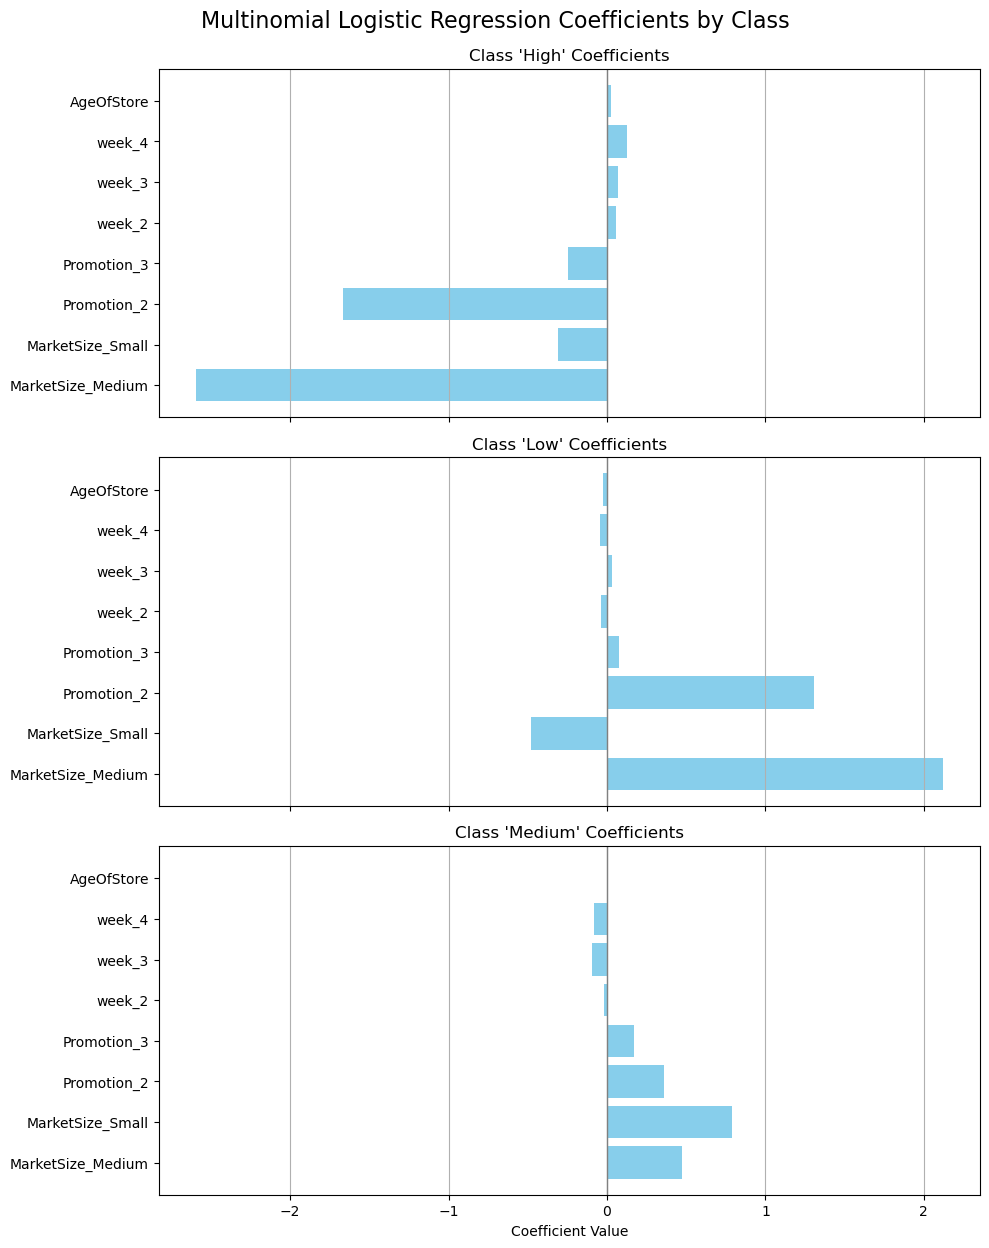

In [105]:
feature_names = X_train.columns
num_features = len(feature_names)
num_classes = len(model.classes_)

# Set up the plot
fig, axes = plt.subplots(num_classes, 1, figsize=(10, 4 * num_classes), sharex=True)

# If only one class (binary), axes may not be iterable
if num_classes == 1:
    axes = [axes]

for i, class_idx in enumerate(model.classes_):
    class_name = le.inverse_transform([class_idx])[0]
    coefs = model.coef_[i]

    axes[i].barh(feature_names, coefs, color='skyblue')
    axes[i].set_title(f"Class '{class_name}' Coefficients")
    axes[i].axvline(0, color='gray', linewidth=1)
    axes[i].grid(True, axis='x')

plt.tight_layout()
plt.xlabel("Coefficient Value")
plt.suptitle("Multinomial Logistic Regression Coefficients by Class", fontsize=16, y=1.02)
plt.show()

# Visualising Odds Ratio of each feature for each class

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Ensure X_train is a DataFrame
feature_names = X_train.columns
num_classes = len(model.classes_)

# Set up the plot
fig, axes = plt.subplots(num_classes, 1, figsize=(10, 4 * num_classes), sharex=True)

if num_classes == 1:
    axes = [axes]  # Make sure axes is iterable

for i, class_idx in enumerate(model.classes_):
    class_name = le.inverse_transform([class_idx])[0]
    coefs = model.coef_[i]
    odds_ratios = np.exp(coefs)

    sns.barplot(x=odds_ratios, hue=feature_names, ax=axes[i], palette="coolwarm",legend=True)
    axes[i].set_title(f"Class '{class_name}' - Odds Ratios")
    axes[i].axvline(1, color='gray', linestyle='--')  # Reference line at OR=1
    axes[i].set_xlabel("Odds Ratio")
    axes[i].set_ylabel("Feature")

plt.tight_layout()
plt.
plt.suptitle("Multinomial Logistic Regression - Odds Ratios by Class", fontsize=16, y=1.02)
plt.show()